## Figure 3(a) plots

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import os
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os
import pickle
import random

import load_data
import models

Using TensorFlow backend.


In [2]:
print("notMNIST")
notMNIST_X_train, notMNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test = load_data.data_notMNIST()
print("MNIST")
MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test = load_data.data_MNIST()

notMNIST
20000 train samples
1000 valid samples
1000 test samples
MNIST
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


In [3]:
def Ensembling_Data(M, MNIST_X_train, MNIST_Y_train):
#     M = 5
    sampled_indices = np.arange(0,MNIST_X_train.shape[0])
    random.shuffle(sampled_indices)

    cut = int(MNIST_X_train.shape[0]/M)
    index_sample_list = []
    for i in range(M):
        index_sample_list.append(sampled_indices[cut*i:cut*(i+1)])
        
    training_X_df = []; training_Y_df = []
    for index_range in index_sample_list:
        training_X_df.append(MNIST_X_train[[index_range]])
        training_Y_df.append(MNIST_Y_train[[index_range]])
        
    return training_X_df, training_Y_df

def NLL(pred_values, MNIST_Y_test, index_of_y):

    from keras import backend as K

    # generate NLL distribution
#     pred_hotcoded = np_utils.to_categorical(pred_values, 10)[index_of_y:index_of_y+1]

    # y_test = y_test.astype('float32') # necessary here, since y_pred comes in this type - check in your case with y_test.dtype and y_pred.dtype
    # y_test = K.constant(y_test)
    # y_pred = K.constant(y_pred)

#     y_pred = K.constant(pred_hotcoded)
    
    y_pred = K.constant(pred_values[index_of_y:index_of_y+1])

    g = K.categorical_crossentropy(target=MNIST_Y_test[index_of_y:index_of_y+1], output=y_pred)  # tensor
    ce = K.eval(g)  # 'ce' for cross-entropy
    ce.shape
    # (10000,) # i.e. one loss quantity per sample

    # sum up and divide with the no. of samples:
    log_loss = np.sum(ce)/ce.shape[0]
#     log_loss
    # 0.05165323486328125
    
    # https://stackoverflow.com/questions/52497625/how-to-calculate-negative-log-likelihoog-on-mnist-dataset
    return log_loss

def entropy_values(MNIST_Y_test, prediction):
    entropy_values=[]
    # Note: To obtain results faster, we use 200 samples for testing purposes
    for i in range(len(MNIST_Y_test[0:200])): # WARNING: Remove 100 limit, let whole dataframe!!!
        log_loss = NLL(prediction, MNIST_Y_test, i)
        entropy_values.append(log_loss)
#         print(i)
    #     print(log_loss)
    return entropy_values

# def entropy_values_faster(MNIST_Y_test, prediction):
# #     entropy_values=[]
# #     for i in range(len(MNIST_Y_test[0:])): # WARNING: Remove 100 limit, let whole dataframe!!!
# #         log_loss = NLL(prediction, MNIST_Y_test, i)
# #         entropy_values.append(log_loss)
#     entropy_values = [NLL(prediction, MNIST_Y_test, i) for i in range(len(MNIST_Y_test))]
#     #     print(log_loss)
#     return entropy_values



In [4]:
def ensembling_expt(M, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, model_function):
    
    training_X_df, training_Y_df = Ensembling_Data(M, MNIST_X_train, MNIST_Y_train)

    prediction_storage=[]
    for i in range(M):
        X_train = training_X_df[i]
        Y_train = training_Y_df[i]
#         model_function = models.MLP()
#         pred = models.MLP(X_train, Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test)
        pred = model_function(X_train, Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test)
        prediction_storage.append(pred)
        
    avg_predictions_from_ensemble=[]
    for j in range(len(prediction_storage[0])):
        tmpList=[]
        for i in range(M):
            tmpList.append(prediction_storage[i][j])
        pred_avg = np.average(tmpList, axis=0)
        avg_predictions_from_ensemble.append(pred_avg)
        
    avg_predictions_from_ensemble2 = np.array([list(i) for i in avg_predictions_from_ensemble])
    entropy_val = entropy_values(MNIST_Y_test, avg_predictions_from_ensemble2)
    
    return entropy_val

### MNIST plots

In [9]:
entropy_val_MLP_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)
entropy_val_MLP_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)
entropy_val_MLP_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 31.92 | Train acc: 0.939 | Test acc:0.937
Epoch:1 | Train loss: 18.14 | Train acc: 0.961 | Test acc:0.956
Epoch:2 | Train loss: 10.69 | Train acc: 0.968 | Test acc:0.960
Epoch:3 | Train loss: 6.58 | Train acc: 0.977 | Test acc:0.969
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Epoch:0 | Train loss: 66.38 | Train acc: 0.881 | Test acc:0.879
Epoch:1 | Train loss: 59.41 | Train acc: 0.909 | Test acc:0.902
Epoch:2 | Train loss: 53.24 | Train acc: 0.927 | Test acc:0.910
Epoch:3 | Train loss: 47.76 | Train acc: 0.943 | Test acc:0.924
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.56 | Train acc: 0.870 | Test acc:0.869
Epoch:1 | Train loss: 53.12 | Train acc: 0.896 | Test acc:0.893
Epoch:2 | Train loss: 47.45 | Train acc: 0.919 | Test acc:0.908
Epoch:3 | Train loss: 42.45 | Train acc: 0.938 | Test acc:0.927
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 50.12 | Train acc: 0.882 | Test acc:0.883
Epoch:1 | Train loss: 44.12 | Train acc: 0.919 | Test acc:0.909
Epoch:2 | Train loss: 38.92 | Train acc: 0.934 | Test acc:0.922
Epoch:3 | Train loss: 34.37 | Train acc: 0.947 | Test acc:0.931
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.05 | Train acc: 0.875 | Test acc:0.869
Epoch:1 | Train loss: 49.59 | Train acc: 0.916 | Test acc:0.907
Epoch:2 | Train loss: 43.94 | Train acc: 0.935 | Test acc:0.922
Epoch:3 | Train loss: 38.97 | Train acc: 0.942 | Test acc:0.923
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.21 | Train acc: 0.873 | Test acc:0.874
Epoch:1 | Train loss: 52.71 | Train acc: 0.910 | Test acc:0.906
Epoch:2 | Train loss: 47.02 | Train acc: 0.922 | Test acc:0.915
Epoch:3 | Train loss: 42.00 | Train acc: 0.933 | Test acc:0.923
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 59.98 | Train acc: 0.781 | Test acc:0.778
Epoch:1 | Train loss: 56.35 | Train acc: 0.851 | Test acc:0.851
Epoch:2 | Train loss: 53.01 | Train acc: 0.879 | Test acc:0.873
Epoch:3 | Train loss: 49.91 | Train acc: 0.892 | Test acc:0.876
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 55.89 | Train acc: 0.800 | Test acc:0.802
Epoch:1 | Train loss: 52.38 | Train acc: 0.850 | Test acc:0.836
Epoch:2 | Train loss: 49.13 | Train acc: 0.860 | Test acc:0.836
Epoch:3 | Train loss: 46.14 | Train acc: 0.880 | Test acc:0.855
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.54 | Train acc: 0.793 | Test acc:0.790
Epoch:1 | Train loss: 55.87 | Train acc: 0.860 | Test acc:0.862
Epoch:2 | Train loss: 52.48 | Train acc: 0.908 | Test acc:0.896
Epoch:3 | Train loss: 49.33 | Train acc: 0.919 | Test acc:0.908
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 61.96 | Train acc: 0.801 | Test acc:0.810
Epoch:1 | Train loss: 58.25 | Train acc: 0.860 | Test acc:0.854
Epoch:2 | Train loss: 54.85 | Train acc: 0.848 | Test acc:0.841
Epoch:3 | Train loss: 51.69 | Train acc: 0.859 | Test acc:0.840
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 54.30 | Train acc: 0.712 | Test acc:0.709
Epoch:1 | Train loss: 50.84 | Train acc: 0.828 | Test acc:0.821
Epoch:2 | Train loss: 47.67 | Train acc: 0.901 | Test acc:0.891
Epoch:3 | Train loss: 44.72 | Train acc: 0.923 | Test acc:0.907
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.30 | Train acc: 0.722 | Test acc:0.716
Epoch:1 | Train loss: 52.75 | Train acc: 0.860 | Test acc:0.852
Epoch:2 | Train loss: 49.52 | Train acc: 0.891 | Test acc:0.867
Epoch:3 | Train loss: 46.50 | Train acc: 0.924 | Test acc:0.900
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.63 | Train acc: 0.800 | Test acc:0.796
Epoch:1 | Train loss: 53.19 | Train acc: 0.861 | Test acc:0.857
Epoch:2 | Train loss: 50.02 | Train acc: 0.896 | Test acc:0.888
Epoch:3 | Train loss: 47.08 | Train acc: 0.913 | Test acc:0.898
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 60.26 | Train acc: 0.681 | Test acc:0.678
Epoch:1 | Train loss: 56.54 | Train acc: 0.853 | Test acc:0.858
Epoch:2 | Train loss: 53.14 | Train acc: 0.867 | Test acc:0.855
Epoch:3 | Train loss: 49.97 | Train acc: 0.911 | Test acc:0.898
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.33 | Train acc: 0.811 | Test acc:0.814
Epoch:1 | Train loss: 52.81 | Train acc: 0.863 | Test acc:0.849
Epoch:2 | Train loss: 49.59 | Train acc: 0.898 | Test acc:0.881
Epoch:3 | Train loss: 46.61 | Train acc: 0.929 | Test acc:0.905
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 58.46 | Train acc: 0.815 | Test acc:0.817
Epoch:1 | Train loss: 54.88 | Train acc: 0.870 | Test acc:0.866
Epoch:2 | Train loss: 51.59 | Train acc: 0.884 | Test acc:0.876
Epoch:3 | Train loss: 48.53 | Train acc: 0.918 | Test acc:0.901
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


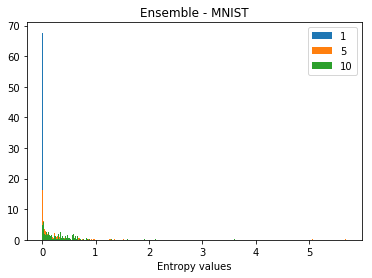

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLP_1, normed=True, bins=300, label = '1')
plt.hist(entropy_val_MLP_5, normed=True, bins=300, label = '5')
plt.hist(entropy_val_MLP_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble - MNIST")
plt.legend()
plt.show()


# import scipy.stats as stats

# density = stats.gaussian_kde(entropy_val_MLP_1)
# n, x, _ = plt.hist(entropy_val_MLP_1, bins=np.linspace(-3, 3, 50), 
#                    histtype=u'step', density=True)  
# plt.plot(x, density(x), label = '1')

# density = stats.gaussian_kde(entropy_val_MLP_5)
# n, x, _ = plt.hist(entropy_val_MLP_5, bins=np.linspace(-3, 3, 50), 
#                    histtype=u'step', density=True)  
# plt.plot(x, density(x), label = '5')

# density = stats.gaussian_kde(entropy_val_MLP_10)
# n, x, _ = plt.hist(entropy_val_MLP_10, bins=np.linspace(-3, 3, 50), 
#                    histtype=u'step', density=True)  
# plt.plot(x, density(x), label = '10')

# plt.xlim(-0.5,)
# plt.legend()
# plt.show()

In [18]:
entropy_val_MLPr_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)
entropy_val_MLPr_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)
entropy_val_MLPr_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((60000, 784), (60000, 10))
Epoch:0 | Train loss: 29.97 | Train acc: 0.922 | Test acc:0.923
Epoch:1 | Train loss: 15.38 | Train acc: 0.952 | Test acc:0.949
Epoch:2 | Train loss: 8.24 | Train acc: 0.923 | Test acc:0.919
Epoch:3 | Train loss: 4.70 | Train acc: 0.945 | Test acc:0.939


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

Without Dropout, MLP with random perturbations


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 49.95 | Train acc: 0.259 | Test acc:0.253
Epoch:1 | Train loss: 43.01 | Train acc: 0.823 | Test acc:0.824
Epoch:2 | Train loss: 37.31 | Train acc: 0.642 | Test acc:0.636
Epoch:3 | Train loss: 32.22 | Train acc: 0.899 | Test acc:0.887
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 49.69 | Train acc: 0.722 | Test acc:0.721
Epoch:1 | Train loss: 42.65 | Train acc: 0.829 | Test acc:0.812
Epoch:2 | Train loss: 36.77 | Train acc: 0.880 | Test acc:0.879
Epoch:3 | Train loss: 31.71 | Train acc: 0.906 | Test acc:0.892
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 54.34 | Train acc: 0.645 | Test acc:0.652
Epoch:1 | Train loss: 47.09 | Train acc: 0.799 | Test acc:0.802
Epoch:2 | Train loss: 40.96 | Train acc: 0.846 | Test acc:0.836
Epoch:3 | Train loss: 35.65 | Train acc: 0.925 | Test acc:0.913
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 57.46 | Train acc: 0.354 | Test acc:0.350
Epoch:1 | Train loss: 49.89 | Train acc: 0.796 | Test acc:0.796
Epoch:2 | Train loss: 43.40 | Train acc: 0.916 | Test acc:0.908
Epoch:3 | Train loss: 37.89 | Train acc: 0.882 | Test acc:0.869
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 53.24 | Train acc: 0.819 | Test acc:0.817
Epoch:1 | Train loss: 46.21 | Train acc: 0.733 | Test acc:0.730
Epoch:2 | Train loss: 40.06 | Train acc: 0.896 | Test acc:0.888
Epoch:3 | Train loss: 34.84 | Train acc: 0.907 | Test acc:0.893


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

Without Dropout, MLP with random perturbations
New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 56.09 | Train acc: 0.576 | Test acc:0.577
Epoch:1 | Train loss: 52.03 | Train acc: 0.738 | Test acc:0.736
Epoch:2 | Train loss: 48.31 | Train acc: 0.870 | Test acc:0.856
Epoch:3 | Train loss: 44.95 | Train acc: 0.873 | Test acc:0.861
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 52.52 | Train acc: 0.563 | Test acc:0.567
Epoch:1 | Train loss: 48.46 | Train acc: 0.789 | Test acc:0.794
Epoch:2 | Train loss: 44.91 | Train acc: 0.836 | Test acc:0.829
Epoch:3 | Train loss: 41.65 | Train acc: 0.886 | Test acc:0.879
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 55.50 | Train acc: 0.574 | Test acc:0.572
Epoch:1 | Train loss: 51.41 | Train acc: 0.778 | Test acc:0.769
Epoch:2 | Train loss: 47.70 | Train acc: 0.878 | Test acc:0.874
Epoch:3 | Train loss: 44.34 | Train acc: 0.898 | Test acc:0.889
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 65.90 | Train acc: 0.521 | Test acc:0.522
Epoch:1 | Train loss: 61.40 | Train acc: 0.820 | Test acc:0.815
Epoch:2 | Train loss: 57.31 | Train acc: 0.881 | Test acc:0.875
Epoch:3 | Train loss: 53.58 | Train acc: 0.895 | Test acc:0.875
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 56.07 | Train acc: 0.591 | Test acc:0.579
Epoch:1 | Train loss: 52.00 | Train acc: 0.822 | Test acc:0.823
Epoch:2 | Train loss: 48.30 | Train acc: 0.881 | Test acc:0.870
Epoch:3 | Train loss: 44.99 | Train acc: 0.790 | Test acc:0.788
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 60.58 | Train acc: 0.706 | Test acc:0.710
Epoch:1 | Train loss: 56.43 | Train acc: 0.740 | Test acc:0.745
Epoch:2 | Train loss: 52.55 | Train acc: 0.842 | Test acc:0.843
Epoch:3 | Train loss: 48.99 | Train acc: 0.886 | Test acc:0.869
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 62.04 | Train acc: 0.681 | Test acc:0.681
Epoch:1 | Train loss: 57.79 | Train acc: 0.683 | Test acc:0.683
Epoch:2 | Train loss: 53.80 | Train acc: 0.816 | Test acc:0.804
Epoch:3 | Train loss: 50.16 | Train acc: 0.892 | Test acc:0.874
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 59.76 | Train acc: 0.272 | Test acc:0.274
Epoch:1 | Train loss: 55.38 | Train acc: 0.646 | Test acc:0.638
Epoch:2 | Train loss: 51.43 | Train acc: 0.822 | Test acc:0.810
Epoch:3 | Train loss: 47.88 | Train acc: 0.872 | Test acc:0.854
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 59.10 | Train acc: 0.568 | Test acc:0.562
Epoch:1 | Train loss: 54.86 | Train acc: 0.858 | Test acc:0.844
Epoch:2 | Train loss: 51.16 | Train acc: 0.799 | Test acc:0.792
Epoch:3 | Train loss: 47.65 | Train acc: 0.856 | Test acc:0.843
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:642: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:643: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 57.37 | Train acc: 0.475 | Test acc:0.469
Epoch:1 | Train loss: 53.32 | Train acc: 0.715 | Test acc:0.720
Epoch:2 | Train loss: 49.60 | Train acc: 0.871 | Test acc:0.866
Epoch:3 | Train loss: 46.39 | Train acc: 0.660 | Test acc:0.649


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


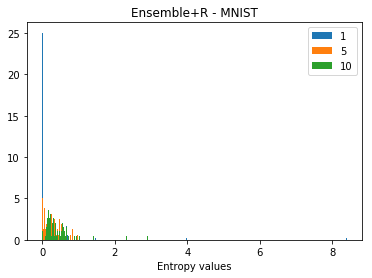

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPr_1, normed=True, bins=300, label = '1')
plt.hist(entropy_val_MLPr_5, normed=True, bins=300, label = '5')
plt.hist(entropy_val_MLPr_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+R - MNIST")
plt.legend()
plt.show()

In [5]:
entropy_val_MLPat_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)
entropy_val_MLPat_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)
entropy_val_MLPat_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout & Batch Normalization


W0211 23:57:07.742873 140409467619072 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:286: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0211 23:57:10.369805 140409467619072 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:299: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0211 23:57:10.375768 140409467619072 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:305: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0211 23:57:10.556560 140409467619072 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:344: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.

W0211 23:57:10.565279 140409467619072 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:346: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimiz

Epoch:0 | Train loss: 34.36 | Train acc: 0.974 | Test acc:0.968
Epoch:1 | Train loss: 19.34 | Train acc: 0.983 | Test acc:0.975
Epoch:2 | Train loss: 11.00 | Train acc: 0.989 | Test acc:0.978
Epoch:3 | Train loss: 6.40 | Train acc: 0.990 | Test acc:0.979
Epoch:4 | Train loss: 3.91 | Train acc: 0.993 | Test acc:0.979
Epoch:5 | Train loss: 2.63 | Train acc: 0.994 | Test acc:0.979
Epoch:6 | Train loss: 1.99 | Train acc: 0.995 | Test acc:0.978
Epoch:7 | Train loss: 1.69 | Train acc: 0.995 | Test acc:0.980
Epoch:8 | Train loss: 1.55 | Train acc: 0.996 | Test acc:0.982
Epoch:9 | Train loss: 1.50 | Train acc: 0.995 | Test acc:0.980
Epoch:10 | Train loss: 1.47 | Train acc: 0.997 | Test acc:0.981
Epoch:11 | Train loss: 1.47 | Train acc: 0.997 | Test acc:0.980
Epoch:12 | Train loss: 1.47 | Train acc: 0.997 | Test acc:0.979
Epoch:13 | Train loss: 1.46 | Train acc: 0.997 | Test acc:0.980
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 30.85 | Train acc: 0.830 | Test acc:0.970
Epoch:1 | Train loss: 16.05 | Train acc: 0.839 | Test acc:0.978
Epoch:2 | Train loss: 8.64 | Train acc: 0.842 | Test acc:0.977
Epoch:3 | Train loss: 4.92 | Train acc: 0.844 | Test acc:0.979
Epoch:4 | Train loss: 3.08 | Train acc: 0.845 | Test acc:0.979
Epoch:5 | Train loss: 2.19 | Train acc: 0.847 | Test acc:0.981
Epoch:6 | Train loss: 1.78 | Train acc: 0.846 | Test acc:0.979
Epoch:7 | Train loss: 1.59 | Train acc: 0.847 | Test acc:0.982
Epoch:8 | Train loss: 1.51 | Train acc: 0.848 | Test acc:0.982
Epoch:9 | Train loss: 1.48 | Train acc: 0.846 | Test acc:0.981
Epoch:10 | Train loss: 1.47 | Train acc: 0.848 | Test acc:0.979
Epoch:11 | Train loss: 1.46 | Train acc: 0.848 | Test acc:0.981
Epoch:12 | Train loss: 1.46 | Train acc: 0.848 | Test acc:0.981
Epoch:13 | Train loss: 1.46 | Train acc: 0.847 | Test acc:0.978


W0211 23:59:30.672978 140409467619072 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0211 23:59:30.677874 140409467619072 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0211 23:59:30.678728 140409467619072 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0211 23:59:30.679668 140409467619072 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

/usr/local/lib/python3.5/dist-packages/ipykern

Without Dropout & Batch Normalization
Epoch:0 | Train loss: 54.69 | Train acc: 0.950 | Test acc:0.933
Epoch:1 | Train loss: 48.48 | Train acc: 0.974 | Test acc:0.949
Epoch:2 | Train loss: 43.07 | Train acc: 0.983 | Test acc:0.954
Epoch:3 | Train loss: 38.32 | Train acc: 0.991 | Test acc:0.961
Epoch:4 | Train loss: 34.15 | Train acc: 0.994 | Test acc:0.963
Epoch:5 | Train loss: 30.46 | Train acc: 0.996 | Test acc:0.964
Epoch:6 | Train loss: 27.20 | Train acc: 0.997 | Test acc:0.965
Epoch:7 | Train loss: 24.31 | Train acc: 0.997 | Test acc:0.963
Epoch:8 | Train loss: 21.75 | Train acc: 0.997 | Test acc:0.963
Epoch:9 | Train loss: 19.47 | Train acc: 0.997 | Test acc:0.965
Epoch:10 | Train loss: 17.45 | Train acc: 0.998 | Test acc:0.963
Epoch:11 | Train loss: 15.64 | Train acc: 0.998 | Test acc:0.966
Epoch:12 | Train loss: 14.04 | Train acc: 0.999 | Test acc:0.967
Epoch:13 | Train loss: 12.62 | Train acc: 0.999 | Test acc:0.966
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 58.24 | Train acc: 0.808 | Test acc:0.937
Epoch:1 | Train loss: 50.60 | Train acc: 0.830 | Test acc:0.951
Epoch:2 | Train loss: 44.05 | Train acc: 0.839 | Test acc:0.960
Epoch:3 | Train loss: 38.39 | Train acc: 0.844 | Test acc:0.961
Epoch:4 | Train loss: 33.50 | Train acc: 0.846 | Test acc:0.961
Epoch:5 | Train loss: 29.25 | Train acc: 0.848 | Test acc:0.966
Epoch:6 | Train loss: 25.57 | Train acc: 0.848 | Test acc:0.963
Epoch:7 | Train loss: 22.36 | Train acc: 0.849 | Test acc:0.966
Epoch:8 | Train loss: 19.58 | Train acc: 0.849 | Test acc:0.966
Epoch:9 | Train loss: 17.14 | Train acc: 0.849 | Test acc:0.966
Epoch:10 | Train loss: 15.03 | Train acc: 0.848 | Test acc:0.967
Epoch:11 | Train loss: 13.18 | Train acc: 0.849 | Test acc:0.964
Epoch:12 | Train loss: 11.57 | Train acc: 0.848 | Test acc:0.966
Epoch:13 | Train loss: 10.17 | Train acc: 0.848 | Test acc:0.965
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 55.35 | Train acc: 0.949 | Test acc:0.932
Epoch:1 | Train loss: 49.07 | Train acc: 0.975 | Test acc:0.947
Epoch:2 | Train loss: 43.59 | Train acc: 0.985 | Test acc:0.957
Epoch:3 | Train loss: 38.78 | Train acc: 0.990 | Test acc:0.960
Epoch:4 | Train loss: 34.54 | Train acc: 0.993 | Test acc:0.963
Epoch:5 | Train loss: 30.79 | Train acc: 0.995 | Test acc:0.961
Epoch:6 | Train loss: 27.46 | Train acc: 0.996 | Test acc:0.961
Epoch:7 | Train loss: 24.52 | Train acc: 0.997 | Test acc:0.966
Epoch:8 | Train loss: 21.90 | Train acc: 0.998 | Test acc:0.965
Epoch:9 | Train loss: 19.58 | Train acc: 0.998 | Test acc:0.965
Epoch:10 | Train loss: 17.52 | Train acc: 0.998 | Test acc:0.963
Epoch:11 | Train loss: 15.68 | Train acc: 0.998 | Test acc:0.962
Epoch:12 | Train loss: 14.05 | Train acc: 0.999 | Test acc:0.961
Epoch:13 | Train loss: 12.60 | Train acc: 0.998 | Test acc:0.959
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 55.05 | Train acc: 0.812 | Test acc:0.939
Epoch:1 | Train loss: 47.97 | Train acc: 0.832 | Test acc:0.956
Epoch:2 | Train loss: 41.92 | Train acc: 0.840 | Test acc:0.957
Epoch:3 | Train loss: 36.70 | Train acc: 0.844 | Test acc:0.962
Epoch:4 | Train loss: 32.19 | Train acc: 0.846 | Test acc:0.962
Epoch:5 | Train loss: 28.27 | Train acc: 0.848 | Test acc:0.963
Epoch:6 | Train loss: 24.87 | Train acc: 0.847 | Test acc:0.964
Epoch:7 | Train loss: 21.90 | Train acc: 0.847 | Test acc:0.964
Epoch:8 | Train loss: 19.30 | Train acc: 0.849 | Test acc:0.966
Epoch:9 | Train loss: 17.04 | Train acc: 0.847 | Test acc:0.966
Epoch:10 | Train loss: 15.06 | Train acc: 0.847 | Test acc:0.966
Epoch:11 | Train loss: 13.32 | Train acc: 0.847 | Test acc:0.964
Epoch:12 | Train loss: 11.80 | Train acc: 0.848 | Test acc:0.964
Epoch:13 | Train loss: 10.47 | Train acc: 0.848 | Test acc:0.967
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.09 | Train acc: 0.944 | Test acc:0.934
Epoch:1 | Train loss: 52.56 | Train acc: 0.972 | Test acc:0.950
Epoch:2 | Train loss: 46.86 | Train acc: 0.983 | Test acc:0.953
Epoch:3 | Train loss: 41.83 | Train acc: 0.990 | Test acc:0.958
Epoch:4 | Train loss: 37.38 | Train acc: 0.993 | Test acc:0.963
Epoch:5 | Train loss: 33.43 | Train acc: 0.993 | Test acc:0.962
Epoch:6 | Train loss: 29.92 | Train acc: 0.996 | Test acc:0.963
Epoch:7 | Train loss: 26.80 | Train acc: 0.997 | Test acc:0.965
Epoch:8 | Train loss: 24.02 | Train acc: 0.997 | Test acc:0.966
Epoch:9 | Train loss: 21.55 | Train acc: 0.997 | Test acc:0.966
Epoch:10 | Train loss: 19.34 | Train acc: 0.997 | Test acc:0.965
Epoch:11 | Train loss: 17.36 | Train acc: 0.998 | Test acc:0.965
Epoch:12 | Train loss: 15.60 | Train acc: 0.998 | Test acc:0.966
Epoch:13 | Train loss: 14.02 | Train acc: 0.998 | Test acc:0.962
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 52.92 | Train acc: 0.811 | Test acc:0.939
Epoch:1 | Train loss: 45.86 | Train acc: 0.830 | Test acc:0.952
Epoch:2 | Train loss: 39.84 | Train acc: 0.839 | Test acc:0.957
Epoch:3 | Train loss: 34.67 | Train acc: 0.844 | Test acc:0.961
Epoch:4 | Train loss: 30.23 | Train acc: 0.843 | Test acc:0.962
Epoch:5 | Train loss: 26.39 | Train acc: 0.845 | Test acc:0.961
Epoch:6 | Train loss: 23.07 | Train acc: 0.847 | Test acc:0.964
Epoch:7 | Train loss: 20.19 | Train acc: 0.847 | Test acc:0.964
Epoch:8 | Train loss: 17.70 | Train acc: 0.850 | Test acc:0.964
Epoch:9 | Train loss: 15.53 | Train acc: 0.846 | Test acc:0.963
Epoch:10 | Train loss: 13.64 | Train acc: 0.848 | Test acc:0.965
Epoch:11 | Train loss: 12.00 | Train acc: 0.848 | Test acc:0.967
Epoch:12 | Train loss: 10.58 | Train acc: 0.847 | Test acc:0.964
Epoch:13 | Train loss: 9.34 | Train acc: 0.848 | Test acc:0.961
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 54.70 | Train acc: 0.945 | Test acc:0.932
Epoch:1 | Train loss: 48.52 | Train acc: 0.975 | Test acc:0.950
Epoch:2 | Train loss: 43.14 | Train acc: 0.986 | Test acc:0.952
Epoch:3 | Train loss: 38.42 | Train acc: 0.991 | Test acc:0.957
Epoch:4 | Train loss: 34.25 | Train acc: 0.993 | Test acc:0.960
Epoch:5 | Train loss: 30.58 | Train acc: 0.995 | Test acc:0.961
Epoch:6 | Train loss: 27.32 | Train acc: 0.997 | Test acc:0.963
Epoch:7 | Train loss: 24.43 | Train acc: 0.997 | Test acc:0.964
Epoch:8 | Train loss: 21.87 | Train acc: 0.997 | Test acc:0.963
Epoch:9 | Train loss: 19.59 | Train acc: 0.998 | Test acc:0.965
Epoch:10 | Train loss: 17.56 | Train acc: 0.998 | Test acc:0.966
Epoch:11 | Train loss: 15.76 | Train acc: 0.998 | Test acc:0.963
Epoch:12 | Train loss: 14.15 | Train acc: 0.998 | Test acc:0.965
Epoch:13 | Train loss: 12.72 | Train acc: 0.998 | Test acc:0.965
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 53.03 | Train acc: 0.814 | Test acc:0.937
Epoch:1 | Train loss: 45.85 | Train acc: 0.836 | Test acc:0.957
Epoch:2 | Train loss: 39.73 | Train acc: 0.843 | Test acc:0.962
Epoch:3 | Train loss: 34.49 | Train acc: 0.847 | Test acc:0.963
Epoch:4 | Train loss: 29.97 | Train acc: 0.846 | Test acc:0.964
Epoch:5 | Train loss: 26.08 | Train acc: 0.848 | Test acc:0.968
Epoch:6 | Train loss: 22.71 | Train acc: 0.849 | Test acc:0.966
Epoch:7 | Train loss: 19.79 | Train acc: 0.851 | Test acc:0.965
Epoch:8 | Train loss: 17.27 | Train acc: 0.850 | Test acc:0.965
Epoch:9 | Train loss: 15.08 | Train acc: 0.851 | Test acc:0.967
Epoch:10 | Train loss: 13.18 | Train acc: 0.849 | Test acc:0.969
Epoch:11 | Train loss: 11.54 | Train acc: 0.849 | Test acc:0.970
Epoch:12 | Train loss: 10.11 | Train acc: 0.851 | Test acc:0.972
Epoch:13 | Train loss: 8.88 | Train acc: 0.850 | Test acc:0.970
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.81 | Train acc: 0.942 | Test acc:0.934
Epoch:1 | Train loss: 53.23 | Train acc: 0.971 | Test acc:0.952
Epoch:2 | Train loss: 47.46 | Train acc: 0.983 | Test acc:0.957
Epoch:3 | Train loss: 42.36 | Train acc: 0.992 | Test acc:0.960
Epoch:4 | Train loss: 37.84 | Train acc: 0.993 | Test acc:0.963
Epoch:5 | Train loss: 33.82 | Train acc: 0.995 | Test acc:0.963
Epoch:6 | Train loss: 30.24 | Train acc: 0.996 | Test acc:0.965
Epoch:7 | Train loss: 27.05 | Train acc: 0.997 | Test acc:0.964
Epoch:8 | Train loss: 24.20 | Train acc: 0.998 | Test acc:0.965
Epoch:9 | Train loss: 21.66 | Train acc: 0.997 | Test acc:0.960
Epoch:10 | Train loss: 19.39 | Train acc: 0.997 | Test acc:0.962
Epoch:11 | Train loss: 17.36 | Train acc: 0.998 | Test acc:0.963
Epoch:12 | Train loss: 15.55 | Train acc: 0.998 | Test acc:0.965
Epoch:13 | Train loss: 13.94 | Train acc: 0.998 | Test acc:0.964
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 56.73 | Train acc: 0.811 | Test acc:0.939
Epoch:1 | Train loss: 49.44 | Train acc: 0.831 | Test acc:0.952
Epoch:2 | Train loss: 43.19 | Train acc: 0.839 | Test acc:0.961
Epoch:3 | Train loss: 37.79 | Train acc: 0.842 | Test acc:0.961
Epoch:4 | Train loss: 33.11 | Train acc: 0.847 | Test acc:0.962
Epoch:5 | Train loss: 29.04 | Train acc: 0.846 | Test acc:0.964
Epoch:6 | Train loss: 25.50 | Train acc: 0.847 | Test acc:0.966
Epoch:7 | Train loss: 22.41 | Train acc: 0.847 | Test acc:0.965
Epoch:8 | Train loss: 19.70 | Train acc: 0.848 | Test acc:0.966
Epoch:9 | Train loss: 17.34 | Train acc: 0.848 | Test acc:0.965
Epoch:10 | Train loss: 15.28 | Train acc: 0.847 | Test acc:0.966
Epoch:11 | Train loss: 13.47 | Train acc: 0.848 | Test acc:0.965
Epoch:12 | Train loss: 11.89 | Train acc: 0.848 | Test acc:0.965
Epoch:13 | Train loss: 10.51 | Train acc: 0.850 | Test acc:0.966


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout & Batch Normalization
Epoch:0 | Train loss: 58.06 | Train acc: 0.919 | Test acc:0.905
Epoch:1 | Train loss: 54.48 | Train acc: 0.958 | Test acc:0.929
Epoch:2 | Train loss: 51.20 | Train acc: 0.973 | Test acc:0.936
Epoch:3 | Train loss: 48.14 | Train acc: 0.986 | Test acc:0.945
Epoch:4 | Train loss: 45.28 | Train acc: 0.990 | Test acc:0.948
Epoch:5 | Train loss: 42.61 | Train acc: 0.994 | Test acc:0.947
Epoch:6 | Train loss: 40.11 | Train acc: 0.995 | Test acc:0.948
Epoch:7 | Train loss: 37.76 | Train acc: 0.997 | Test acc:0.950
Epoch:8 | Train loss: 35.56 | Train acc: 0.997 | Test acc:0.951
Epoch:9 | Train loss: 33.50 | Train acc: 0.997 | Test acc:0.947
Epoch:10 | Train loss: 31.55 | Train acc: 0.998 | Test acc:0.949
Epoch:11 | Train loss: 29.73 | Train acc: 0.997 | Test acc:0.948
Epoch:12 | Train loss: 28.02 | Train acc: 0.998 | Test acc:0.947
Epoch:13 | Train loss: 26.41 | Train acc: 0.998 | Test acc:0.946
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 67.47 | Train acc: 0.795 | Test acc:0.912
Epoch:1 | Train loss: 62.93 | Train acc: 0.823 | Test acc:0.935
Epoch:2 | Train loss: 58.77 | Train acc: 0.834 | Test acc:0.944
Epoch:3 | Train loss: 54.91 | Train acc: 0.842 | Test acc:0.947
Epoch:4 | Train loss: 51.33 | Train acc: 0.846 | Test acc:0.948
Epoch:5 | Train loss: 48.00 | Train acc: 0.846 | Test acc:0.951
Epoch:6 | Train loss: 44.89 | Train acc: 0.847 | Test acc:0.951
Epoch:7 | Train loss: 42.00 | Train acc: 0.849 | Test acc:0.952
Epoch:8 | Train loss: 39.31 | Train acc: 0.848 | Test acc:0.953
Epoch:9 | Train loss: 36.79 | Train acc: 0.849 | Test acc:0.953
Epoch:10 | Train loss: 34.44 | Train acc: 0.847 | Test acc:0.952
Epoch:11 | Train loss: 32.25 | Train acc: 0.846 | Test acc:0.953
Epoch:12 | Train loss: 30.20 | Train acc: 0.849 | Test acc:0.952
Epoch:13 | Train loss: 28.29 | Train acc: 0.848 | Test acc:0.949
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 63.97 | Train acc: 0.922 | Test acc:0.907
Epoch:1 | Train loss: 60.22 | Train acc: 0.959 | Test acc:0.932
Epoch:2 | Train loss: 56.76 | Train acc: 0.978 | Test acc:0.943
Epoch:3 | Train loss: 53.52 | Train acc: 0.987 | Test acc:0.941
Epoch:4 | Train loss: 50.50 | Train acc: 0.989 | Test acc:0.946
Epoch:5 | Train loss: 47.65 | Train acc: 0.994 | Test acc:0.949
Epoch:6 | Train loss: 44.98 | Train acc: 0.995 | Test acc:0.951
Epoch:7 | Train loss: 42.47 | Train acc: 0.996 | Test acc:0.951
Epoch:8 | Train loss: 40.11 | Train acc: 0.995 | Test acc:0.950
Epoch:9 | Train loss: 37.89 | Train acc: 0.996 | Test acc:0.950
Epoch:10 | Train loss: 35.80 | Train acc: 0.997 | Test acc:0.953
Epoch:11 | Train loss: 33.82 | Train acc: 0.997 | Test acc:0.949
Epoch:12 | Train loss: 31.96 | Train acc: 0.998 | Test acc:0.951
Epoch:13 | Train loss: 30.21 | Train acc: 0.998 | Test acc:0.951
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 56.55 | Train acc: 0.792 | Test acc:0.911
Epoch:1 | Train loss: 52.45 | Train acc: 0.823 | Test acc:0.937
Epoch:2 | Train loss: 48.72 | Train acc: 0.839 | Test acc:0.943
Epoch:3 | Train loss: 45.28 | Train acc: 0.847 | Test acc:0.945
Epoch:4 | Train loss: 42.11 | Train acc: 0.847 | Test acc:0.949
Epoch:5 | Train loss: 39.17 | Train acc: 0.848 | Test acc:0.951
Epoch:6 | Train loss: 36.46 | Train acc: 0.848 | Test acc:0.951
Epoch:7 | Train loss: 33.94 | Train acc: 0.849 | Test acc:0.954
Epoch:8 | Train loss: 31.61 | Train acc: 0.848 | Test acc:0.951
Epoch:9 | Train loss: 29.44 | Train acc: 0.850 | Test acc:0.956
Epoch:10 | Train loss: 27.43 | Train acc: 0.850 | Test acc:0.953
Epoch:11 | Train loss: 25.56 | Train acc: 0.850 | Test acc:0.955
Epoch:12 | Train loss: 23.83 | Train acc: 0.852 | Test acc:0.954
Epoch:13 | Train loss: 22.22 | Train acc: 0.848 | Test acc:0.956
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 57.66 | Train acc: 0.916 | Test acc:0.899
Epoch:1 | Train loss: 54.17 | Train acc: 0.962 | Test acc:0.929
Epoch:2 | Train loss: 50.98 | Train acc: 0.977 | Test acc:0.940
Epoch:3 | Train loss: 48.02 | Train acc: 0.987 | Test acc:0.945
Epoch:4 | Train loss: 45.25 | Train acc: 0.991 | Test acc:0.944
Epoch:5 | Train loss: 42.67 | Train acc: 0.994 | Test acc:0.950
Epoch:6 | Train loss: 40.26 | Train acc: 0.994 | Test acc:0.945
Epoch:7 | Train loss: 37.99 | Train acc: 0.995 | Test acc:0.949
Epoch:8 | Train loss: 35.86 | Train acc: 0.996 | Test acc:0.951
Epoch:9 | Train loss: 33.86 | Train acc: 0.995 | Test acc:0.949
Epoch:10 | Train loss: 31.99 | Train acc: 0.997 | Test acc:0.948
Epoch:11 | Train loss: 30.22 | Train acc: 0.997 | Test acc:0.950
Epoch:12 | Train loss: 28.56 | Train acc: 0.997 | Test acc:0.951
Epoch:13 | Train loss: 27.00 | Train acc: 0.997 | Test acc:0.952
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 53.97 | Train acc: 0.771 | Test acc:0.872
Epoch:1 | Train loss: 49.90 | Train acc: 0.827 | Test acc:0.935
Epoch:2 | Train loss: 46.25 | Train acc: 0.840 | Test acc:0.945
Epoch:3 | Train loss: 42.90 | Train acc: 0.845 | Test acc:0.949
Epoch:4 | Train loss: 39.82 | Train acc: 0.844 | Test acc:0.952
Epoch:5 | Train loss: 36.96 | Train acc: 0.850 | Test acc:0.952
Epoch:6 | Train loss: 34.33 | Train acc: 0.847 | Test acc:0.956
Epoch:7 | Train loss: 31.89 | Train acc: 0.846 | Test acc:0.957
Epoch:8 | Train loss: 29.63 | Train acc: 0.847 | Test acc:0.958
Epoch:9 | Train loss: 27.54 | Train acc: 0.847 | Test acc:0.955
Epoch:10 | Train loss: 25.61 | Train acc: 0.851 | Test acc:0.956
Epoch:11 | Train loss: 23.81 | Train acc: 0.852 | Test acc:0.956
Epoch:12 | Train loss: 22.15 | Train acc: 0.849 | Test acc:0.959
Epoch:13 | Train loss: 20.61 | Train acc: 0.848 | Test acc:0.958
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 60.54 | Train acc: 0.918 | Test acc:0.906
Epoch:1 | Train loss: 56.84 | Train acc: 0.960 | Test acc:0.934
Epoch:2 | Train loss: 53.45 | Train acc: 0.978 | Test acc:0.938
Epoch:3 | Train loss: 50.29 | Train acc: 0.985 | Test acc:0.946
Epoch:4 | Train loss: 47.34 | Train acc: 0.989 | Test acc:0.948
Epoch:5 | Train loss: 44.57 | Train acc: 0.992 | Test acc:0.952
Epoch:6 | Train loss: 41.98 | Train acc: 0.995 | Test acc:0.952
Epoch:7 | Train loss: 39.55 | Train acc: 0.995 | Test acc:0.953
Epoch:8 | Train loss: 37.27 | Train acc: 0.996 | Test acc:0.951
Epoch:9 | Train loss: 35.13 | Train acc: 0.997 | Test acc:0.953
Epoch:10 | Train loss: 33.11 | Train acc: 0.996 | Test acc:0.951
Epoch:11 | Train loss: 31.22 | Train acc: 0.996 | Test acc:0.949
Epoch:12 | Train loss: 29.44 | Train acc: 0.996 | Test acc:0.951
Epoch:13 | Train loss: 27.76 | Train acc: 0.997 | Test acc:0.950
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 53.94 | Train acc: 0.782 | Test acc:0.905
Epoch:1 | Train loss: 50.03 | Train acc: 0.829 | Test acc:0.938
Epoch:2 | Train loss: 46.51 | Train acc: 0.839 | Test acc:0.948
Epoch:3 | Train loss: 43.28 | Train acc: 0.844 | Test acc:0.954
Epoch:4 | Train loss: 40.30 | Train acc: 0.843 | Test acc:0.955
Epoch:5 | Train loss: 37.55 | Train acc: 0.844 | Test acc:0.955
Epoch:6 | Train loss: 35.00 | Train acc: 0.848 | Test acc:0.956
Epoch:7 | Train loss: 32.65 | Train acc: 0.848 | Test acc:0.958
Epoch:8 | Train loss: 30.46 | Train acc: 0.849 | Test acc:0.959
Epoch:9 | Train loss: 28.43 | Train acc: 0.849 | Test acc:0.958
Epoch:10 | Train loss: 26.55 | Train acc: 0.850 | Test acc:0.958
Epoch:11 | Train loss: 24.81 | Train acc: 0.848 | Test acc:0.960
Epoch:12 | Train loss: 23.19 | Train acc: 0.848 | Test acc:0.958
Epoch:13 | Train loss: 21.68 | Train acc: 0.849 | Test acc:0.958
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 62.15 | Train acc: 0.926 | Test acc:0.909
Epoch:1 | Train loss: 58.46 | Train acc: 0.962 | Test acc:0.935
Epoch:2 | Train loss: 55.06 | Train acc: 0.980 | Test acc:0.941
Epoch:3 | Train loss: 51.89 | Train acc: 0.989 | Test acc:0.946
Epoch:4 | Train loss: 48.93 | Train acc: 0.994 | Test acc:0.948
Epoch:5 | Train loss: 46.15 | Train acc: 0.992 | Test acc:0.948
Epoch:6 | Train loss: 43.54 | Train acc: 0.995 | Test acc:0.951
Epoch:7 | Train loss: 41.09 | Train acc: 0.997 | Test acc:0.952
Epoch:8 | Train loss: 38.78 | Train acc: 0.997 | Test acc:0.951
Epoch:9 | Train loss: 36.62 | Train acc: 0.998 | Test acc:0.952
Epoch:10 | Train loss: 34.58 | Train acc: 0.998 | Test acc:0.952
Epoch:11 | Train loss: 32.67 | Train acc: 0.998 | Test acc:0.953
Epoch:12 | Train loss: 30.86 | Train acc: 0.999 | Test acc:0.953
Epoch:13 | Train loss: 29.17 | Train acc: 0.998 | Test acc:0.948
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 58.82 | Train acc: 0.798 | Test acc:0.915
Epoch:1 | Train loss: 54.67 | Train acc: 0.831 | Test acc:0.937
Epoch:2 | Train loss: 50.89 | Train acc: 0.839 | Test acc:0.945
Epoch:3 | Train loss: 47.40 | Train acc: 0.845 | Test acc:0.946
Epoch:4 | Train loss: 44.17 | Train acc: 0.846 | Test acc:0.947
Epoch:5 | Train loss: 41.18 | Train acc: 0.849 | Test acc:0.951
Epoch:6 | Train loss: 38.41 | Train acc: 0.851 | Test acc:0.952
Epoch:7 | Train loss: 35.84 | Train acc: 0.848 | Test acc:0.954
Epoch:8 | Train loss: 33.45 | Train acc: 0.851 | Test acc:0.956
Epoch:9 | Train loss: 31.23 | Train acc: 0.847 | Test acc:0.956
Epoch:10 | Train loss: 29.16 | Train acc: 0.850 | Test acc:0.957
Epoch:11 | Train loss: 27.24 | Train acc: 0.848 | Test acc:0.956
Epoch:12 | Train loss: 25.45 | Train acc: 0.849 | Test acc:0.955
Epoch:13 | Train loss: 23.78 | Train acc: 0.850 | Test acc:0.956
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.83 | Train acc: 0.919 | Test acc:0.906
Epoch:1 | Train loss: 56.19 | Train acc: 0.962 | Test acc:0.930
Epoch:2 | Train loss: 52.84 | Train acc: 0.980 | Test acc:0.937
Epoch:3 | Train loss: 49.73 | Train acc: 0.989 | Test acc:0.944
Epoch:4 | Train loss: 46.82 | Train acc: 0.993 | Test acc:0.947
Epoch:5 | Train loss: 44.10 | Train acc: 0.996 | Test acc:0.948
Epoch:6 | Train loss: 41.56 | Train acc: 0.997 | Test acc:0.949
Epoch:7 | Train loss: 39.17 | Train acc: 0.997 | Test acc:0.949
Epoch:8 | Train loss: 36.93 | Train acc: 0.998 | Test acc:0.949
Epoch:9 | Train loss: 34.83 | Train acc: 0.997 | Test acc:0.951
Epoch:10 | Train loss: 32.86 | Train acc: 0.998 | Test acc:0.948
Epoch:11 | Train loss: 31.01 | Train acc: 0.998 | Test acc:0.947
Epoch:12 | Train loss: 29.26 | Train acc: 0.998 | Test acc:0.951
Epoch:13 | Train loss: 27.63 | Train acc: 0.998 | Test acc:0.946
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 61.75 | Train acc: 0.786 | Test acc:0.900
Epoch:1 | Train loss: 57.48 | Train acc: 0.824 | Test acc:0.932
Epoch:2 | Train loss: 53.58 | Train acc: 0.839 | Test acc:0.941
Epoch:3 | Train loss: 49.98 | Train acc: 0.844 | Test acc:0.944
Epoch:4 | Train loss: 46.65 | Train acc: 0.846 | Test acc:0.948
Epoch:5 | Train loss: 43.56 | Train acc: 0.848 | Test acc:0.948
Epoch:6 | Train loss: 40.69 | Train acc: 0.849 | Test acc:0.950
Epoch:7 | Train loss: 38.02 | Train acc: 0.847 | Test acc:0.951
Epoch:8 | Train loss: 35.54 | Train acc: 0.849 | Test acc:0.953
Epoch:9 | Train loss: 33.22 | Train acc: 0.850 | Test acc:0.951
Epoch:10 | Train loss: 31.07 | Train acc: 0.851 | Test acc:0.952
Epoch:11 | Train loss: 29.06 | Train acc: 0.850 | Test acc:0.955
Epoch:12 | Train loss: 27.19 | Train acc: 0.849 | Test acc:0.953
Epoch:13 | Train loss: 25.44 | Train acc: 0.850 | Test acc:0.953
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 62.51 | Train acc: 0.914 | Test acc:0.902
Epoch:1 | Train loss: 58.76 | Train acc: 0.956 | Test acc:0.934
Epoch:2 | Train loss: 55.31 | Train acc: 0.976 | Test acc:0.943
Epoch:3 | Train loss: 52.10 | Train acc: 0.985 | Test acc:0.943
Epoch:4 | Train loss: 49.09 | Train acc: 0.991 | Test acc:0.948
Epoch:5 | Train loss: 46.28 | Train acc: 0.994 | Test acc:0.948
Epoch:6 | Train loss: 43.64 | Train acc: 0.995 | Test acc:0.950
Epoch:7 | Train loss: 41.17 | Train acc: 0.996 | Test acc:0.948
Epoch:8 | Train loss: 38.84 | Train acc: 0.995 | Test acc:0.949
Epoch:9 | Train loss: 36.66 | Train acc: 0.995 | Test acc:0.949
Epoch:10 | Train loss: 34.60 | Train acc: 0.997 | Test acc:0.949
Epoch:11 | Train loss: 32.68 | Train acc: 0.996 | Test acc:0.950
Epoch:12 | Train loss: 30.86 | Train acc: 0.997 | Test acc:0.948
Epoch:13 | Train loss: 29.15 | Train acc: 0.995 | Test acc:0.948
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 56.81 | Train acc: 0.788 | Test acc:0.918
Epoch:1 | Train loss: 52.74 | Train acc: 0.822 | Test acc:0.937
Epoch:2 | Train loss: 49.03 | Train acc: 0.835 | Test acc:0.945
Epoch:3 | Train loss: 45.61 | Train acc: 0.843 | Test acc:0.948
Epoch:4 | Train loss: 42.44 | Train acc: 0.848 | Test acc:0.952
Epoch:5 | Train loss: 39.51 | Train acc: 0.849 | Test acc:0.951
Epoch:6 | Train loss: 36.79 | Train acc: 0.852 | Test acc:0.955
Epoch:7 | Train loss: 34.27 | Train acc: 0.850 | Test acc:0.957
Epoch:8 | Train loss: 31.92 | Train acc: 0.849 | Test acc:0.957
Epoch:9 | Train loss: 29.75 | Train acc: 0.850 | Test acc:0.957
Epoch:10 | Train loss: 27.72 | Train acc: 0.849 | Test acc:0.957
Epoch:11 | Train loss: 25.84 | Train acc: 0.850 | Test acc:0.957
Epoch:12 | Train loss: 24.08 | Train acc: 0.849 | Test acc:0.955
Epoch:13 | Train loss: 22.45 | Train acc: 0.850 | Test acc:0.957
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 63.86 | Train acc: 0.925 | Test acc:0.912
Epoch:1 | Train loss: 60.04 | Train acc: 0.960 | Test acc:0.932
Epoch:2 | Train loss: 56.50 | Train acc: 0.977 | Test acc:0.940
Epoch:3 | Train loss: 53.20 | Train acc: 0.984 | Test acc:0.943
Epoch:4 | Train loss: 50.10 | Train acc: 0.991 | Test acc:0.948
Epoch:5 | Train loss: 47.20 | Train acc: 0.993 | Test acc:0.950
Epoch:6 | Train loss: 44.47 | Train acc: 0.994 | Test acc:0.953
Epoch:7 | Train loss: 41.91 | Train acc: 0.995 | Test acc:0.947
Epoch:8 | Train loss: 39.49 | Train acc: 0.996 | Test acc:0.948
Epoch:9 | Train loss: 37.22 | Train acc: 0.998 | Test acc:0.951
Epoch:10 | Train loss: 35.08 | Train acc: 0.997 | Test acc:0.947
Epoch:11 | Train loss: 33.07 | Train acc: 0.997 | Test acc:0.945
Epoch:12 | Train loss: 31.17 | Train acc: 0.998 | Test acc:0.949
Epoch:13 | Train loss: 29.38 | Train acc: 0.998 | Test acc:0.950
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 57.34 | Train acc: 0.786 | Test acc:0.911
Epoch:1 | Train loss: 53.32 | Train acc: 0.826 | Test acc:0.936
Epoch:2 | Train loss: 49.66 | Train acc: 0.837 | Test acc:0.945
Epoch:3 | Train loss: 46.30 | Train acc: 0.842 | Test acc:0.952
Epoch:4 | Train loss: 43.19 | Train acc: 0.848 | Test acc:0.952
Epoch:5 | Train loss: 40.31 | Train acc: 0.847 | Test acc:0.953
Epoch:6 | Train loss: 37.65 | Train acc: 0.848 | Test acc:0.956
Epoch:7 | Train loss: 35.18 | Train acc: 0.851 | Test acc:0.953
Epoch:8 | Train loss: 32.88 | Train acc: 0.849 | Test acc:0.955
Epoch:9 | Train loss: 30.75 | Train acc: 0.848 | Test acc:0.957
Epoch:10 | Train loss: 28.76 | Train acc: 0.847 | Test acc:0.955
Epoch:11 | Train loss: 26.91 | Train acc: 0.846 | Test acc:0.957
Epoch:12 | Train loss: 25.19 | Train acc: 0.850 | Test acc:0.959
Epoch:13 | Train loss: 23.58 | Train acc: 0.850 | Test acc:0.956
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.35 | Train acc: 0.929 | Test acc:0.905
Epoch:1 | Train loss: 55.81 | Train acc: 0.962 | Test acc:0.928
Epoch:2 | Train loss: 52.55 | Train acc: 0.976 | Test acc:0.938
Epoch:3 | Train loss: 49.53 | Train acc: 0.987 | Test acc:0.942
Epoch:4 | Train loss: 46.70 | Train acc: 0.990 | Test acc:0.944
Epoch:5 | Train loss: 44.05 | Train acc: 0.992 | Test acc:0.944
Epoch:6 | Train loss: 41.57 | Train acc: 0.995 | Test acc:0.945
Epoch:7 | Train loss: 39.24 | Train acc: 0.996 | Test acc:0.947
Epoch:8 | Train loss: 37.04 | Train acc: 0.997 | Test acc:0.949
Epoch:9 | Train loss: 34.98 | Train acc: 0.996 | Test acc:0.945
Epoch:10 | Train loss: 33.05 | Train acc: 0.996 | Test acc:0.947
Epoch:11 | Train loss: 31.22 | Train acc: 0.996 | Test acc:0.947
Epoch:12 | Train loss: 29.50 | Train acc: 0.997 | Test acc:0.948
Epoch:13 | Train loss: 27.88 | Train acc: 0.997 | Test acc:0.948
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 56.47 | Train acc: 0.801 | Test acc:0.915
Epoch:1 | Train loss: 52.35 | Train acc: 0.831 | Test acc:0.935
Epoch:2 | Train loss: 48.60 | Train acc: 0.839 | Test acc:0.941
Epoch:3 | Train loss: 45.16 | Train acc: 0.848 | Test acc:0.948
Epoch:4 | Train loss: 41.98 | Train acc: 0.848 | Test acc:0.949
Epoch:5 | Train loss: 39.04 | Train acc: 0.845 | Test acc:0.950
Epoch:6 | Train loss: 36.32 | Train acc: 0.850 | Test acc:0.951
Epoch:7 | Train loss: 33.81 | Train acc: 0.847 | Test acc:0.952
Epoch:8 | Train loss: 31.49 | Train acc: 0.848 | Test acc:0.951
Epoch:9 | Train loss: 29.33 | Train acc: 0.848 | Test acc:0.950
Epoch:10 | Train loss: 27.33 | Train acc: 0.853 | Test acc:0.954
Epoch:11 | Train loss: 25.48 | Train acc: 0.848 | Test acc:0.953
Epoch:12 | Train loss: 23.76 | Train acc: 0.850 | Test acc:0.955
Epoch:13 | Train loss: 22.17 | Train acc: 0.850 | Test acc:0.954
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 58.53 | Train acc: 0.924 | Test acc:0.906
Epoch:1 | Train loss: 55.07 | Train acc: 0.959 | Test acc:0.934
Epoch:2 | Train loss: 51.90 | Train acc: 0.975 | Test acc:0.940
Epoch:3 | Train loss: 48.94 | Train acc: 0.985 | Test acc:0.944
Epoch:4 | Train loss: 46.20 | Train acc: 0.989 | Test acc:0.946
Epoch:5 | Train loss: 43.62 | Train acc: 0.991 | Test acc:0.947
Epoch:6 | Train loss: 41.22 | Train acc: 0.992 | Test acc:0.948
Epoch:7 | Train loss: 38.95 | Train acc: 0.995 | Test acc:0.952
Epoch:8 | Train loss: 36.83 | Train acc: 0.996 | Test acc:0.953
Epoch:9 | Train loss: 34.84 | Train acc: 0.997 | Test acc:0.954
Epoch:10 | Train loss: 32.98 | Train acc: 0.997 | Test acc:0.950
Epoch:11 | Train loss: 31.22 | Train acc: 0.997 | Test acc:0.953
Epoch:12 | Train loss: 29.56 | Train acc: 0.997 | Test acc:0.952
Epoch:13 | Train loss: 28.00 | Train acc: 0.998 | Test acc:0.954
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:415: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 50.57 | Train acc: 0.777 | Test acc:0.908
Epoch:1 | Train loss: 46.78 | Train acc: 0.820 | Test acc:0.934
Epoch:2 | Train loss: 43.35 | Train acc: 0.834 | Test acc:0.944
Epoch:3 | Train loss: 40.22 | Train acc: 0.840 | Test acc:0.948
Epoch:4 | Train loss: 37.34 | Train acc: 0.845 | Test acc:0.949
Epoch:5 | Train loss: 34.69 | Train acc: 0.844 | Test acc:0.953
Epoch:6 | Train loss: 32.24 | Train acc: 0.846 | Test acc:0.953
Epoch:7 | Train loss: 29.98 | Train acc: 0.845 | Test acc:0.954
Epoch:8 | Train loss: 27.90 | Train acc: 0.846 | Test acc:0.954
Epoch:9 | Train loss: 25.96 | Train acc: 0.848 | Test acc:0.956
Epoch:10 | Train loss: 24.18 | Train acc: 0.846 | Test acc:0.956
Epoch:11 | Train loss: 22.52 | Train acc: 0.845 | Test acc:0.957
Epoch:12 | Train loss: 20.99 | Train acc: 0.847 | Test acc:0.957
Epoch:13 | Train loss: 19.57 | Train acc: 0.846 | Test acc:0.957


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


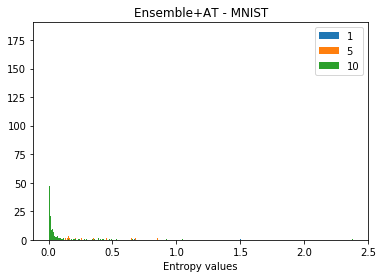

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPat_1, normed=True, bins=300, label = '1')
plt.hist(entropy_val_MLPat_5, normed=True, bins=300, label = '5')
plt.hist(entropy_val_MLPat_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+AT - MNIST")
plt.legend()
plt.show()

In [9]:
# M in MC dropout refers to number of MC dropout samples; since we're sampling different sets of indices, sort of sampling~

entropy_val_MLPmc_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)
entropy_val_MLPmc_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)
entropy_val_MLPmc_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


With Dropout & Batch Normalization


W0211 23:46:50.459547 140327648077568 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:157: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0211 23:46:53.183253 140327648077568 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:170: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0211 23:46:53.189158 140327648077568 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:176: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0211 23:46:53.283526 140327648077568 deprecation.py:506] From /home/root/adversarial/Gal/models.py:191: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0211 23:46:53.396448 140327648077568 module_wrapper.py:139] From /home

Epoch:0 | Train loss: 30.45 | Train acc: 0.948 | Test acc:0.945
Epoch:1 | Train loss: 16.91 | Train acc: 0.967 | Test acc:0.963
Epoch:2 | Train loss: 9.58 | Train acc: 0.973 | Test acc:0.966
Epoch:3 | Train loss: 5.62 | Train acc: 0.980 | Test acc:0.973
Epoch:4 | Train loss: 3.53 | Train acc: 0.982 | Test acc:0.973
Epoch:5 | Train loss: 2.45 | Train acc: 0.984 | Test acc:0.976
Epoch:6 | Train loss: 1.91 | Train acc: 0.987 | Test acc:0.979
Epoch:7 | Train loss: 1.66 | Train acc: 0.987 | Test acc:0.978
Epoch:8 | Train loss: 1.55 | Train acc: 0.987 | Test acc:0.976
Epoch:9 | Train loss: 1.50 | Train acc: 0.990 | Test acc:0.980
Epoch:10 | Train loss: 1.48 | Train acc: 0.990 | Test acc:0.977
Epoch:11 | Train loss: 1.47 | Train acc: 0.991 | Test acc:0.978
Epoch:12 | Train loss: 1.47 | Train acc: 0.991 | Test acc:0.977
Epoch:13 | Train loss: 1.47 | Train acc: 0.991 | Test acc:0.978


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[node Placeholder (defined at /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[Sigmoid/_145]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[node Placeholder (defined at /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'Placeholder':
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a40c7eb2c95d>", line 3, in <module>
    entropy_val_MLPmc_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)
  File "<ipython-input-8-cea88605c474>", line 11, in ensembling_expt
    pred = model_function(X_train, Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test)
  File "/home/root/adversarial/Gal/models.py", line 186, in MCDropout
    keep_prob = tf.placeholder(tf.float32)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPmc_1, normed=True, bins=300, label = '1')
plt.hist(entropy_val_MLPmc_5, normed=True, bins=300, label = '5')
plt.hist(entropy_val_MLPmc_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("MC Dropout 0.1 - MNIST")
plt.legend()
plt.show()

### notMNIST plots

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 31.96 | Train acc: 0.939 | Test acc:0.072
Epoch:1 | Train loss: 17.95 | Train acc: 0.959 | Test acc:0.059
Epoch:2 | Train loss: 10.34 | Train acc: 0.967 | Test acc:0.065
Epoch:3 | Train loss: 6.16 | Train acc: 0.977 | Test acc:0.078


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 57.33 | Train acc: 0.876 | Test acc:0.065
Epoch:1 | Train loss: 50.98 | Train acc: 0.905 | Test acc:0.061
Epoch:2 | Train loss: 45.43 | Train acc: 0.925 | Test acc:0.066
Epoch:3 | Train loss: 40.52 | Train acc: 0.944 | Test acc:0.060
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 52.89 | Train acc: 0.859 | Test acc:0.054
Epoch:1 | Train loss: 46.88 | Train acc: 0.888 | Test acc:0.054
Epoch:2 | Train loss: 41.65 | Train acc: 0.928 | Test acc:0.046
Epoch:3 | Train loss: 37.07 | Train acc: 0.940 | Test acc:0.039
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 52.55 | Train acc: 0.868 | Test acc:0.065
Epoch:1 | Train loss: 46.46 | Train acc: 0.906 | Test acc:0.061
Epoch:2 | Train loss: 41.16 | Train acc: 0.931 | Test acc:0.053
Epoch:3 | Train loss: 36.52 | Train acc: 0.943 | Test acc:0.054
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 57.30 | Train acc: 0.866 | Test acc:0.053
Epoch:1 | Train loss: 50.87 | Train acc: 0.910 | Test acc:0.059
Epoch:2 | Train loss: 45.24 | Train acc: 0.933 | Test acc:0.069
Epoch:3 | Train loss: 40.29 | Train acc: 0.939 | Test acc:0.062
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 57.75 | Train acc: 0.868 | Test acc:0.057
Epoch:1 | Train loss: 51.21 | Train acc: 0.916 | Test acc:0.047
Epoch:2 | Train loss: 45.48 | Train acc: 0.930 | Test acc:0.048
Epoch:3 | Train loss: 40.43 | Train acc: 0.944 | Test acc:0.063


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 57.11 | Train acc: 0.815 | Test acc:0.043
Epoch:1 | Train loss: 53.64 | Train acc: 0.873 | Test acc:0.065
Epoch:2 | Train loss: 50.47 | Train acc: 0.905 | Test acc:0.052
Epoch:3 | Train loss: 47.52 | Train acc: 0.917 | Test acc:0.056
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 61.71 | Train acc: 0.823 | Test acc:0.064
Epoch:1 | Train loss: 58.04 | Train acc: 0.866 | Test acc:0.073
Epoch:2 | Train loss: 54.65 | Train acc: 0.900 | Test acc:0.052
Epoch:3 | Train loss: 51.50 | Train acc: 0.916 | Test acc:0.047
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.65 | Train acc: 0.777 | Test acc:0.066
Epoch:1 | Train loss: 53.09 | Train acc: 0.845 | Test acc:0.051
Epoch:2 | Train loss: 49.81 | Train acc: 0.872 | Test acc:0.065
Epoch:3 | Train loss: 46.78 | Train acc: 0.902 | Test acc:0.060
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 58.09 | Train acc: 0.771 | Test acc:0.074
Epoch:1 | Train loss: 54.57 | Train acc: 0.878 | Test acc:0.050
Epoch:2 | Train loss: 51.34 | Train acc: 0.894 | Test acc:0.050
Epoch:3 | Train loss: 48.34 | Train acc: 0.904 | Test acc:0.061
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 60.80 | Train acc: 0.780 | Test acc:0.070
Epoch:1 | Train loss: 57.12 | Train acc: 0.873 | Test acc:0.078
Epoch:2 | Train loss: 53.76 | Train acc: 0.893 | Test acc:0.069
Epoch:3 | Train loss: 50.63 | Train acc: 0.925 | Test acc:0.067
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 61.72 | Train acc: 0.799 | Test acc:0.074
Epoch:1 | Train loss: 57.98 | Train acc: 0.872 | Test acc:0.059
Epoch:2 | Train loss: 54.57 | Train acc: 0.905 | Test acc:0.041
Epoch:3 | Train loss: 51.37 | Train acc: 0.932 | Test acc:0.044
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 54.73 | Train acc: 0.767 | Test acc:0.071
Epoch:1 | Train loss: 51.21 | Train acc: 0.868 | Test acc:0.054
Epoch:2 | Train loss: 48.03 | Train acc: 0.885 | Test acc:0.056
Epoch:3 | Train loss: 45.06 | Train acc: 0.917 | Test acc:0.062
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 57.05 | Train acc: 0.818 | Test acc:0.069
Epoch:1 | Train loss: 53.56 | Train acc: 0.881 | Test acc:0.067
Epoch:2 | Train loss: 50.37 | Train acc: 0.868 | Test acc:0.066
Epoch:3 | Train loss: 47.40 | Train acc: 0.905 | Test acc:0.078
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 54.93 | Train acc: 0.725 | Test acc:0.107
Epoch:1 | Train loss: 51.51 | Train acc: 0.872 | Test acc:0.078
Epoch:2 | Train loss: 48.39 | Train acc: 0.891 | Test acc:0.079
Epoch:3 | Train loss: 45.50 | Train acc: 0.916 | Test acc:0.077
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 58.04 | Train acc: 0.799 | Test acc:0.058
Epoch:1 | Train loss: 54.43 | Train acc: 0.864 | Test acc:0.057
Epoch:2 | Train loss: 51.11 | Train acc: 0.898 | Test acc:0.068
Epoch:3 | Train loss: 48.03 | Train acc: 0.917 | Test acc:0.059


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


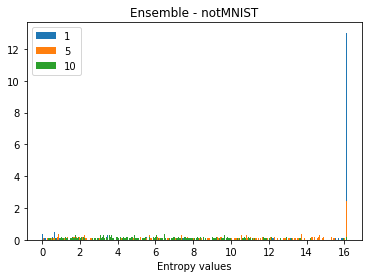

In [7]:
Nentropy_val_MLP_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)
Nentropy_val_MLP_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)
Nentropy_val_MLP_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLP_1, normed=True, bins=300, label = '1')
plt.hist(Nentropy_val_MLP_5, normed=True, bins=300, label = '5')
plt.hist(Nentropy_val_MLP_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble - notMNIST")
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((60000, 784), (60000, 10))
Epoch:0 | Train loss: 28.01 | Train acc: 0.846 | Test acc:0.061
Epoch:1 | Train loss: 13.99 | Train acc: 0.910 | Test acc:0.066
Epoch:2 | Train loss: 7.22 | Train acc: 0.969 | Test acc:0.073
Epoch:3 | Train loss: 4.04 | Train acc: 0.954 | Test acc:0.085


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

Without Dropout, MLP with random perturbations


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 59.27 | Train acc: 0.586 | Test acc:0.079
Epoch:1 | Train loss: 51.62 | Train acc: 0.904 | Test acc:0.050
Epoch:2 | Train loss: 45.25 | Train acc: 0.905 | Test acc:0.077
Epoch:3 | Train loss: 39.72 | Train acc: 0.900 | Test acc:0.077
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 53.81 | Train acc: 0.723 | Test acc:0.042
Epoch:1 | Train loss: 46.65 | Train acc: 0.658 | Test acc:0.074
Epoch:2 | Train loss: 40.47 | Train acc: 0.910 | Test acc:0.057
Epoch:3 | Train loss: 35.21 | Train acc: 0.904 | Test acc:0.084
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 57.68 | Train acc: 0.596 | Test acc:0.068
Epoch:1 | Train loss: 50.36 | Train acc: 0.669 | Test acc:0.062
Epoch:2 | Train loss: 44.01 | Train acc: 0.862 | Test acc:0.094
Epoch:3 | Train loss: 38.66 | Train acc: 0.774 | Test acc:0.088
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 54.75 | Train acc: 0.671 | Test acc:0.101
Epoch:1 | Train loss: 47.52 | Train acc: 0.668 | Test acc:0.066
Epoch:2 | Train loss: 41.15 | Train acc: 0.913 | Test acc:0.048
Epoch:3 | Train loss: 35.79 | Train acc: 0.937 | Test acc:0.074
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((12000, 784), (12000, 10))
Epoch:0 | Train loss: 49.93 | Train acc: 0.496 | Test acc:0.060
Epoch:1 | Train loss: 42.94 | Train acc: 0.870 | Test acc:0.051
Epoch:2 | Train loss: 37.13 | Train acc: 0.882 | Test acc:0.039
Epoch:3 | Train loss: 32.13 | Train acc: 0.938 | Test acc:0.031


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

Without Dropout, MLP with random perturbations


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 60.25 | Train acc: 0.554 | Test acc:0.062
Epoch:1 | Train loss: 55.92 | Train acc: 0.805 | Test acc:0.057
Epoch:2 | Train loss: 52.01 | Train acc: 0.878 | Test acc:0.047
Epoch:3 | Train loss: 48.46 | Train acc: 0.859 | Test acc:0.056
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 58.44 | Train acc: 0.500 | Test acc:0.081
Epoch:1 | Train loss: 54.24 | Train acc: 0.701 | Test acc:0.049
Epoch:2 | Train loss: 50.38 | Train acc: 0.860 | Test acc:0.062
Epoch:3 | Train loss: 46.88 | Train acc: 0.864 | Test acc:0.057
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 60.49 | Train acc: 0.674 | Test acc:0.052
Epoch:1 | Train loss: 56.27 | Train acc: 0.818 | Test acc:0.047
Epoch:2 | Train loss: 52.46 | Train acc: 0.883 | Test acc:0.041
Epoch:3 | Train loss: 49.04 | Train acc: 0.671 | Test acc:0.041
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 56.78 | Train acc: 0.587 | Test acc:0.056
Epoch:1 | Train loss: 52.54 | Train acc: 0.746 | Test acc:0.077
Epoch:2 | Train loss: 48.74 | Train acc: 0.856 | Test acc:0.059
Epoch:3 | Train loss: 45.26 | Train acc: 0.844 | Test acc:0.085
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 55.69 | Train acc: 0.723 | Test acc:0.061
Epoch:1 | Train loss: 51.87 | Train acc: 0.720 | Test acc:0.050
Epoch:2 | Train loss: 48.31 | Train acc: 0.815 | Test acc:0.088
Epoch:3 | Train loss: 45.01 | Train acc: 0.904 | Test acc:0.069
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 58.14 | Train acc: 0.670 | Test acc:0.090
Epoch:1 | Train loss: 54.09 | Train acc: 0.630 | Test acc:0.060
Epoch:2 | Train loss: 50.31 | Train acc: 0.837 | Test acc:0.050
Epoch:3 | Train loss: 46.97 | Train acc: 0.574 | Test acc:0.054
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 61.91 | Train acc: 0.657 | Test acc:0.051
Epoch:1 | Train loss: 57.62 | Train acc: 0.791 | Test acc:0.038
Epoch:2 | Train loss: 53.69 | Train acc: 0.818 | Test acc:0.061
Epoch:3 | Train loss: 50.06 | Train acc: 0.893 | Test acc:0.045
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 52.84 | Train acc: 0.747 | Test acc:0.041
Epoch:1 | Train loss: 48.85 | Train acc: 0.760 | Test acc:0.040
Epoch:2 | Train loss: 45.24 | Train acc: 0.719 | Test acc:0.058
Epoch:3 | Train loss: 41.83 | Train acc: 0.821 | Test acc:0.050
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 59.88 | Train acc: 0.552 | Test acc:0.102
Epoch:1 | Train loss: 55.62 | Train acc: 0.793 | Test acc:0.046
Epoch:2 | Train loss: 51.85 | Train acc: 0.792 | Test acc:0.081
Epoch:3 | Train loss: 48.27 | Train acc: 0.910 | Test acc:0.062
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:644: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:645: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((6000, 784), (6000, 10))
Epoch:0 | Train loss: 58.14 | Train acc: 0.197 | Test acc:0.072
Epoch:1 | Train loss: 53.73 | Train acc: 0.788 | Test acc:0.065
Epoch:2 | Train loss: 49.98 | Train acc: 0.632 | Test acc:0.077
Epoch:3 | Train loss: 46.40 | Train acc: 0.856 | Test acc:0.055


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


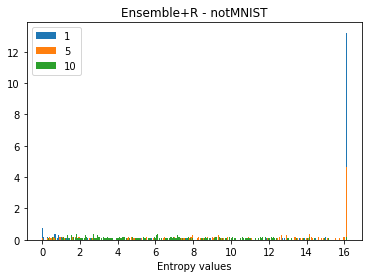

In [ ]:
Nentropy_val_MLPr_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)
Nentropy_val_MLPr_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)
Nentropy_val_MLPr_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPr_1, normed=True, bins=300, label = '1')
plt.hist(Nentropy_val_MLPr_5, normed=True, bins=300, label = '5')
plt.hist(Nentropy_val_MLPr_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+R - notMNIST")
plt.legend()
plt.show()

In [5]:
Nentropy_val_MLPat_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)
Nentropy_val_MLPat_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)
Nentropy_val_MLPat_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPat_1, normed=True, bins=300, label = '1')
plt.hist(Nentropy_val_MLPat_5, normed=True, bins=300, label = '5')
plt.hist(Nentropy_val_MLPat_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+AT - notMNIST")
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout & Batch Normalization


W0212 01:58:57.334360 140379776665344 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:287: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0212 01:58:59.724544 140379776665344 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:300: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0212 01:58:59.730072 140379776665344 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:306: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0212 01:58:59.909603 140379776665344 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:345: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.

W0212 01:58:59.918474 140379776665344 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:347: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimiz

Epoch:0 | Train loss: 35.90 | Train acc: 0.973 | Test acc:0.114
Epoch:1 | Train loss: 20.64 | Train acc: 0.984 | Test acc:0.099
Epoch:2 | Train loss: 12.19 | Train acc: 0.988 | Test acc:0.085
Epoch:3 | Train loss: 7.44 | Train acc: 0.991 | Test acc:0.088
Epoch:4 | Train loss: 4.73 | Train acc: 0.993 | Test acc:0.092
Epoch:5 | Train loss: 3.20 | Train acc: 0.994 | Test acc:0.095
Epoch:6 | Train loss: 2.34 | Train acc: 0.994 | Test acc:0.092
Epoch:7 | Train loss: 1.88 | Train acc: 0.996 | Test acc:0.087
Epoch:8 | Train loss: 1.64 | Train acc: 0.996 | Test acc:0.097
Epoch:9 | Train loss: 1.53 | Train acc: 0.997 | Test acc:0.086
Epoch:10 | Train loss: 1.49 | Train acc: 0.997 | Test acc:0.069
Epoch:11 | Train loss: 1.47 | Train acc: 0.997 | Test acc:0.080
Epoch:12 | Train loss: 1.47 | Train acc: 0.997 | Test acc:0.066
Epoch:13 | Train loss: 1.47 | Train acc: 0.996 | Test acc:0.068
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 32.74 | Train acc: 0.830 | Test acc:0.098
Epoch:1 | Train loss: 16.81 | Train acc: 0.838 | Test acc:0.079
Epoch:2 | Train loss: 8.87 | Train acc: 0.842 | Test acc:0.079
Epoch:3 | Train loss: 4.94 | Train acc: 0.843 | Test acc:0.079
Epoch:4 | Train loss: 3.05 | Train acc: 0.842 | Test acc:0.070
Epoch:5 | Train loss: 2.16 | Train acc: 0.845 | Test acc:0.088
Epoch:6 | Train loss: 1.76 | Train acc: 0.846 | Test acc:0.082
Epoch:7 | Train loss: 1.58 | Train acc: 0.846 | Test acc:0.093
Epoch:8 | Train loss: 1.51 | Train acc: 0.847 | Test acc:0.085
Epoch:9 | Train loss: 1.48 | Train acc: 0.848 | Test acc:0.096
Epoch:10 | Train loss: 1.47 | Train acc: 0.846 | Test acc:0.106
Epoch:11 | Train loss: 1.47 | Train acc: 0.847 | Test acc:0.103
Epoch:12 | Train loss: 1.46 | Train acc: 0.847 | Test acc:0.100


W0212 02:01:18.792056 140379776665344 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0212 02:01:18.796486 140379776665344 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0212 02:01:18.797173 140379776665344 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0212 02:01:18.797918 140379776665344 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



Epoch:13 | Train loss: 1.46 | Train acc: 0.847 | Test acc:0.091


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout & Batch Normalization
Epoch:0 | Train loss: 47.02 | Train acc: 0.948 | Test acc:0.120
Epoch:1 | Train loss: 41.30 | Train acc: 0.973 | Test acc:0.111
Epoch:2 | Train loss: 36.35 | Train acc: 0.984 | Test acc:0.123
Epoch:3 | Train loss: 32.05 | Train acc: 0.988 | Test acc:0.124
Epoch:4 | Train loss: 28.29 | Train acc: 0.993 | Test acc:0.128
Epoch:5 | Train loss: 25.00 | Train acc: 0.995 | Test acc:0.125
Epoch:6 | Train loss: 22.11 | Train acc: 0.995 | Test acc:0.125
Epoch:7 | Train loss: 19.57 | Train acc: 0.996 | Test acc:0.113
Epoch:8 | Train loss: 17.34 | Train acc: 0.997 | Test acc:0.123
Epoch:9 | Train loss: 15.37 | Train acc: 0.998 | Test acc:0.115
Epoch:10 | Train loss: 13.64 | Train acc: 0.998 | Test acc:0.107
Epoch:11 | Train loss: 12.12 | Train acc: 0.998 | Test acc:0.089
Epoch:12 | Train loss: 10.77 | Train acc: 0.998 | Test acc:0.110
Epoch:13 | Train loss: 9.59 | Train acc: 0.998 | Test acc:0.090
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 57.54 | Train acc: 0.810 | Test acc:0.149
Epoch:1 | Train loss: 50.15 | Train acc: 0.833 | Test acc:0.135
Epoch:2 | Train loss: 43.80 | Train acc: 0.840 | Test acc:0.149
Epoch:3 | Train loss: 38.33 | Train acc: 0.843 | Test acc:0.137
Epoch:4 | Train loss: 33.59 | Train acc: 0.845 | Test acc:0.134
Epoch:5 | Train loss: 29.46 | Train acc: 0.845 | Test acc:0.123
Epoch:6 | Train loss: 25.87 | Train acc: 0.849 | Test acc:0.115
Epoch:7 | Train loss: 22.75 | Train acc: 0.848 | Test acc:0.116
Epoch:8 | Train loss: 20.02 | Train acc: 0.848 | Test acc:0.142
Epoch:9 | Train loss: 17.63 | Train acc: 0.849 | Test acc:0.143
Epoch:10 | Train loss: 15.55 | Train acc: 0.847 | Test acc:0.118
Epoch:11 | Train loss: 13.73 | Train acc: 0.849 | Test acc:0.118
Epoch:12 | Train loss: 12.14 | Train acc: 0.850 | Test acc:0.120
Epoch:13 | Train loss: 10.75 | Train acc: 0.849 | Test acc:0.125
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 59.50 | Train acc: 0.946 | Test acc:0.128
Epoch:1 | Train loss: 53.03 | Train acc: 0.974 | Test acc:0.134
Epoch:2 | Train loss: 47.36 | Train acc: 0.983 | Test acc:0.117
Epoch:3 | Train loss: 42.36 | Train acc: 0.990 | Test acc:0.126
Epoch:4 | Train loss: 37.94 | Train acc: 0.992 | Test acc:0.114
Epoch:5 | Train loss: 34.01 | Train acc: 0.994 | Test acc:0.105
Epoch:6 | Train loss: 30.52 | Train acc: 0.996 | Test acc:0.116
Epoch:7 | Train loss: 27.40 | Train acc: 0.996 | Test acc:0.095
Epoch:8 | Train loss: 24.62 | Train acc: 0.997 | Test acc:0.101
Epoch:9 | Train loss: 22.14 | Train acc: 0.998 | Test acc:0.101
Epoch:10 | Train loss: 19.92 | Train acc: 0.998 | Test acc:0.111
Epoch:11 | Train loss: 17.93 | Train acc: 0.997 | Test acc:0.105
Epoch:12 | Train loss: 16.15 | Train acc: 0.998 | Test acc:0.082
Epoch:13 | Train loss: 14.56 | Train acc: 0.998 | Test acc:0.092
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 55.42 | Train acc: 0.813 | Test acc:0.104
Epoch:1 | Train loss: 48.10 | Train acc: 0.829 | Test acc:0.112
Epoch:2 | Train loss: 41.84 | Train acc: 0.839 | Test acc:0.080
Epoch:3 | Train loss: 36.46 | Train acc: 0.846 | Test acc:0.087
Epoch:4 | Train loss: 31.82 | Train acc: 0.846 | Test acc:0.063
Epoch:5 | Train loss: 27.81 | Train acc: 0.847 | Test acc:0.074
Epoch:6 | Train loss: 24.33 | Train acc: 0.850 | Test acc:0.074
Epoch:7 | Train loss: 21.31 | Train acc: 0.848 | Test acc:0.079
Epoch:8 | Train loss: 18.69 | Train acc: 0.849 | Test acc:0.077
Epoch:9 | Train loss: 16.41 | Train acc: 0.847 | Test acc:0.086
Epoch:10 | Train loss: 14.43 | Train acc: 0.850 | Test acc:0.075
Epoch:11 | Train loss: 12.70 | Train acc: 0.848 | Test acc:0.081
Epoch:12 | Train loss: 11.20 | Train acc: 0.848 | Test acc:0.090
Epoch:13 | Train loss: 9.89 | Train acc: 0.850 | Test acc:0.098
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 58.15 | Train acc: 0.945 | Test acc:0.101
Epoch:1 | Train loss: 51.67 | Train acc: 0.973 | Test acc:0.109
Epoch:2 | Train loss: 46.00 | Train acc: 0.986 | Test acc:0.100
Epoch:3 | Train loss: 41.01 | Train acc: 0.990 | Test acc:0.102
Epoch:4 | Train loss: 36.59 | Train acc: 0.994 | Test acc:0.095
Epoch:5 | Train loss: 32.68 | Train acc: 0.995 | Test acc:0.084
Epoch:6 | Train loss: 29.22 | Train acc: 0.996 | Test acc:0.087
Epoch:7 | Train loss: 26.13 | Train acc: 0.997 | Test acc:0.096
Epoch:8 | Train loss: 23.40 | Train acc: 0.997 | Test acc:0.092
Epoch:9 | Train loss: 20.96 | Train acc: 0.998 | Test acc:0.076
Epoch:10 | Train loss: 18.79 | Train acc: 0.998 | Test acc:0.097
Epoch:11 | Train loss: 16.86 | Train acc: 0.998 | Test acc:0.092
Epoch:12 | Train loss: 15.13 | Train acc: 0.998 | Test acc:0.103
Epoch:13 | Train loss: 13.60 | Train acc: 0.998 | Test acc:0.098
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 54.68 | Train acc: 0.810 | Test acc:0.102
Epoch:1 | Train loss: 47.34 | Train acc: 0.834 | Test acc:0.091
Epoch:2 | Train loss: 41.07 | Train acc: 0.840 | Test acc:0.088
Epoch:3 | Train loss: 35.68 | Train acc: 0.844 | Test acc:0.106
Epoch:4 | Train loss: 31.03 | Train acc: 0.845 | Test acc:0.100
Epoch:5 | Train loss: 27.00 | Train acc: 0.848 | Test acc:0.084
Epoch:6 | Train loss: 23.52 | Train acc: 0.847 | Test acc:0.090
Epoch:7 | Train loss: 20.50 | Train acc: 0.848 | Test acc:0.084
Epoch:8 | Train loss: 17.88 | Train acc: 0.850 | Test acc:0.080
Epoch:9 | Train loss: 15.61 | Train acc: 0.851 | Test acc:0.096
Epoch:10 | Train loss: 13.65 | Train acc: 0.848 | Test acc:0.097
Epoch:11 | Train loss: 11.94 | Train acc: 0.848 | Test acc:0.104
Epoch:12 | Train loss: 10.46 | Train acc: 0.848 | Test acc:0.108


KeyboardInterrupt: 

In [ ]:
# M in MC dropout refers to number of MC dropout samples; since we're sampling different sets of indices, sort of sampling~

Nentropy_val_MLPmc_1 = ensembling_expt(1, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)
Nentropy_val_MLPmc_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)
Nentropy_val_MLPmc_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPmc_1, normed=True, bins=300, label = '1')
plt.hist(Nentropy_val_MLPmc_5, normed=True, bins=300, label = '5')
plt.hist(Nentropy_val_MLPmc_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("MC Dropout 0.1 - notMNIST")
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


With Dropout & Batch Normalization


W0212 03:20:45.652128 140392798648064 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:158: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0212 03:20:47.866004 140392798648064 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:171: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0212 03:20:47.870998 140392798648064 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:177: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0212 03:20:47.958550 140392798648064 deprecation.py:506] From /home/root/adversarial/Gal/models.py:192: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0212 03:20:48.070690 140392798648064 module_wrapper.py:139] From /home

Epoch:0 | Train loss: 28.40 | Train acc: 0.947 | Test acc:0.130


In [ ]:
# entropy_val_MLP_1, acc_MLP_1
# entropy_val_MLP_5, acc_MLP_5
# entropy_val_MLP_10, acc_MLP_10
# entropy_val_MLPr_1, acc_MLPr_1
# entropy_val_MLPr_5, acc_MLPr_5
# entropy_val_MLPr_10, acc_MLPr_10
# entropy_val_MLPat_1, acc_MLPat_1
# entropy_val_MLPat_5, acc_MLPat_5
# entropy_val_MLPat_10, acc_MLPat_10
# entropy_val_MLPmc_1, acc_MLPmc_1
# entropy_val_MLPmc_5, acc_MLPmc_5
# entropy_val_MLPmc_10, acc_MLPmc_10
# Nentropy_val_MLP_1, Nacc_MLP_1
# Nentropy_val_MLP_5, Nacc_MLP_5
# Nentropy_val_MLP_10, Nacc_MLP_10
# Nentropy_val_MLPr_1, Nacc_MLPr_1
# Nentropy_val_MLPr_5, Nacc_MLPr_5
# Nentropy_val_MLPr_10, Nacc_MLPr_10
# Nentropy_val_MLPat_1, Nacc_MLPat_1
# Nentropy_val_MLPat_5, Nacc_MLPat_5 
# Nentropy_val_MLPat_10, Nacc_MLPat_10
# Nentropy_val_MLPmc_1, Nacc_MLPmc_1
# Nentropy_val_MLPmc_5, Nacc_MLPmc_5
# Nentropy_val_MLPmc_10, Nacc_MLPmc_10